In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os
import sys
import math
import numpy as np
import matplotlib as mpl
import seaborn as sns
import tensorflow as tf
from tqdm.notebook import tqdm, trange
from IPython.display import HTML
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.path import Path
from matplotlib.patches import Rectangle, PathPatch
from tensorflow import keras as K
from sklearn.preprocessing import minmax_scale
from sklearn.decomposition import PCA
from sklearn.utils import shuffle

# sys.path.append('../../SketchRNN_tf2')
from sketchrnn_ouatai import models, dataset, utils

sns.set('notebook', 'whitegrid', rc=utils.mpl_rc())

print("tf: {}".format(tf.version.VERSION))
print("tf.keras: {}".format(K.__version__))

2021-09-07 11:57:55.725422: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-09-07 11:57:55.725619: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


tf: 2.6.0
tf.keras: 2.6.0


In [2]:
import IProgress
import ipywidgets
import random
from PIL import Image
import io
import pandas as pd

## dessine moi un objet

In [8]:
def dessine_moi_un(word, temperature = 0.2, color = 'black', zoom = 1):
#     words = ['airplane', 'apple','bat', 'bee', 'bird', 'bread', 'butterfly', 'candle', 'cat', 'church', 'cloud', 'crab', 'cup', 'dolphin', 'dragon', 'envelope', 'face', 'firetruck', 'frog', 'grass', 'hammer', 'knife', 'leaf', 'lollipop', 'mushroom', 'owl', 'pants', 'pear', 'postcard', 'radio', 'sheep', 'skull', 'snake', 'square', 'sword', 't-shirt', 'teddy-bear', 'train', 'windmill', 'The Eiffel Tower', 'angel', 'banana', 'bear', 'bench', 'book', 'broom', 'bulldozer', 'bus', 'cactus', 'camel', 'car', 'cello', 'circle', 'cookie','crocodile', 'diamond', 'donut', 'drums', 'eraser', 'feather', 'fish', 'flower', 'giraffe', 'guitar', 'harp', 'hedgehog', 'hourglass', 'jail', 'ladder', 'lighter', 'mailbox', 'moon', 'mountain', 'ocean', 'palm tree', 'parachute','pencil', 'pineapple', 'potato', 'rain', 'rifle', 'school bus', 'shorts', 'smiley face', 'snowflake', 'sock', 'stairs', 'submarine', 'syringe', 'telephone', 'tree','umbrella', 'whale', 'zigzag']
#     if word not in words:
#         raise 'WordNotFoundError'
    
    #test de variables random
    best_images = np.load(f'../../raw_data/Best_images/best_{word}.npy', allow_pickle=True)
    max_seq_len = best_images[0].shape[0]-1
    data_train = [1 for k in range(10000)]
    
    hps = {
        "max_seq_len": max_seq_len,
        'batch_size': 100,
        "num_batches": math.ceil(len(data_train) / 100),
        "epochs": 1,
        "recurrent_dropout_prob": 0.1,
        "enc_rnn_size": 256,
        "dec_rnn_size": 512,
        "z_size": 128,
        "num_mixture": 20,
        "learning_rate": 0.001,
        "min_learning_rate": 0.00001,
        "decay_rate": 0.9999,
        "grad_clip": 1.0,
        'kl_tolerance': 0.2,
        'kl_decay_rate': 0.99995,
        "kl_weight": 0.5,
        'kl_weight_start': 0.01,
    }
    
    # load model
    sketchrnn = models.SketchRNN(hps)
    initial_epoch, initial_loss = 100, 0.06
    
     
    checkpoint = os.path.join('../../SketchRNN_tf2/models/models 100 epochs/', f"{word}.hdf5")
    sketchrnn.load_weights(checkpoint);
    
    
    # building image 
    best_pic = random.choice(best_images)
    d = np.expand_dims(best_pic,0)
    z = sketchrnn.models['encoder'].predict(d[:,1:])[0]
    strokes = sketchrnn.sample(z=z, temperature=temperature)
    
    final_object = utils.to_normal_strokes(strokes)
    figsize = (3*zoom,3*zoom)
    fig, ax = plt.subplots(figsize=figsize);
    utils.plot_strokes(ax, final_object, ec = color, lw = lw);
#     utils.plt_save(filename = '../../raw_data/Best_images/best_'+word+'.svg', facecolor = 'red')
#     plt.savefig(fname = '../../raw_data/Best_images/best_'+word+'.png', facecolor = background)
    
    # figure to PIL image
    buf = io.BytesIO()
    fig.savefig(buf, format='png', transparent = True)
    buf.seek(0)
    image = Image.open(buf)
#     image.save("../../raw_data/Best_images/best_cat_buffer.png")
    image = image.copy()
    buf.close()
    return image

In [10]:
word = 'burger'
best_images = np.load(f'../../raw_data/Best_images/best_{word}.npy', allow_pickle=True)
fig, axs = plt.subplots(2, 10, figsize=(20, 4))
for index, ax in enumerate(axs[0]):
    utils.plot_strokes(ax, utils.to_normal_strokes(best_images[index]))
for index, ax in enumerate(axs[1]):
    utils.plot_strokes(ax, utils.to_normal_strokes(best_images[index+10]))

FileNotFoundError: [Errno 2] No such file or directory: '../../raw_data/Best_images/best_burger.npy'

In [4]:
len(best_images)

20

In [9]:
burger = dessine_moi_un('burger', color = 'green', zoom = 1)

FileNotFoundError: [Errno 2] No such file or directory: '../../raw_data/Best_images/best_burger.npy'

In [88]:
bulldozer.size

(167, 163)

## la scene

In [89]:
scene_size = (2_000, 1_000)

In [90]:
def construis_la_scene(list_objects, scene_size = scene_size):
    '''
    list_objects = [[img_obj1, position_obj1], ...]
    '''
    scene = Image.new('RGBA', scene_size)
    for obj in list_objects:
        scene.paste(obj[0], obj[1])
    return scene

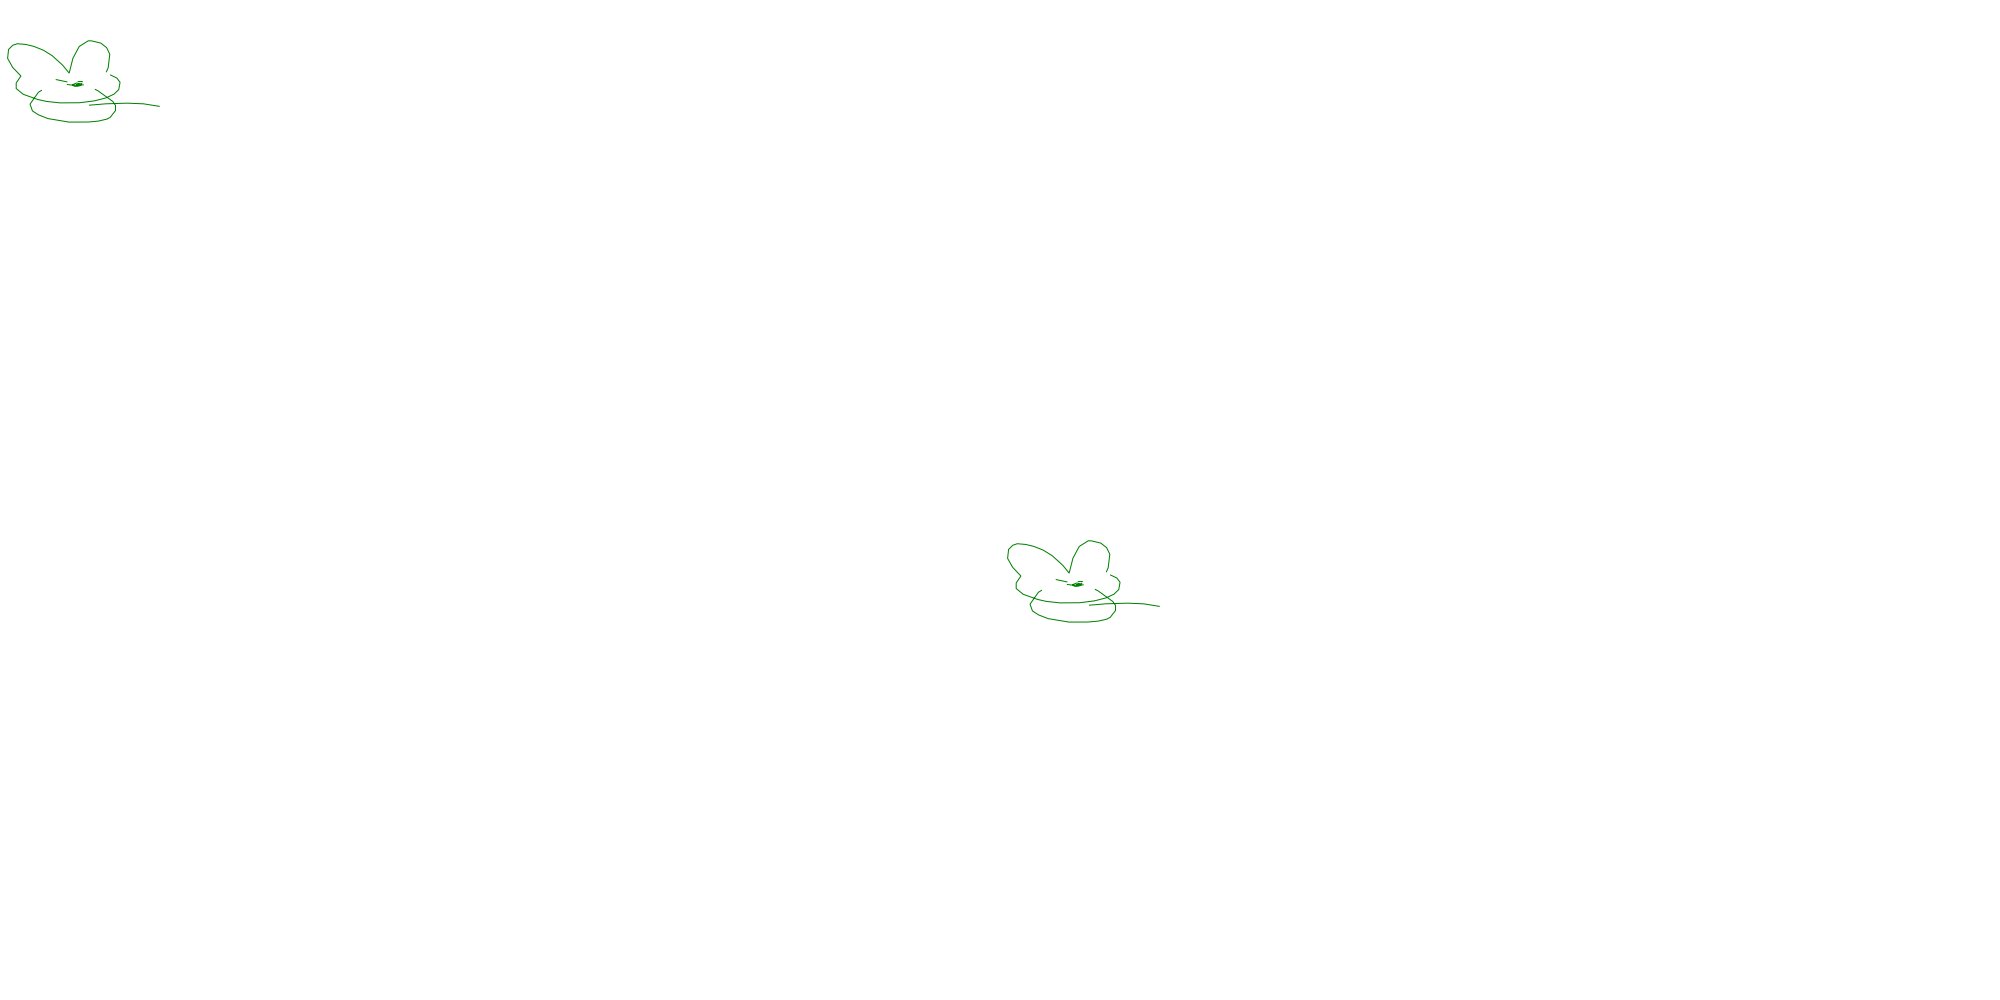

In [91]:

construis_la_scene([[bulldozer, (0,0)],[bulldozer, (1000,500)]])

In [156]:
df = pd.DataFrame(np.array([['cat', 'blue', 'small', 3, 'centre', 'middle'], 
                             ['bulldozer', 'orange', 'big', 1, 'bottom', 'right'], 
                             ['face', 'brown', 'medium', 1, 'top', 'left'],
                             ['rifle', 'red', 'medium', 2, 'bottom', 'middle']
                            ]),
                   columns=['category', 'color', 'size', 'num', 'vertical_position', 'horizontal_position'])
df

,category,color,size,num,vertical_position,horizontal_position
0,cat,blue,small,3,centre,middle
1,bulldozer,orange,big,1,bottom,right
2,face,brown,medium,1,top,left
3,rifle,red,medium,2,bottom,middle


In [157]:
from PIL import ImageDraw

In [158]:
def df_to_scene(df, scene_size = scene_size):
    list_objects = []
    list_position = []
    vertical_positions = {
        'top' : 0,
        'centre' : int(scene_size[1]/3),
        'bottom' : int(2*scene_size[1]/3)
    }
    horizontal_positions = {
        'left' : 0,
        'middle' : int(scene_size[0]/3),
        'right' : int(2*scene_size[0]/3)
    }
    sizes = {
        'small' : 1/2,
        'medium' : 1,
        'big' : 2
    }
    for index, row in df.iterrows():
#         print(f'{index},{row}')
#         print
        for n in range(int(row['num'])):            
            category = row['category']
            print('category', category)
            color = row['color']
            size = sizes[row['size']]
            image = dessine_moi_un(category, color = color, zoom = size)
            print('type image', type(image))
            print('image size', image.size)
            imgwidth, imgheight = image.size
            #position
            starthoriz = horizontal_positions[row['horizontal_position']]
            stophoriz = starthoriz + (horizontal_positions['middle'] - imgwidth)
            startvert = vertical_positions[row['vertical_position']]
            stopvert = startvert + (vertical_positions['centre'] - imgheight)
            hor = random.randint(starthoriz,stophoriz)
            vert = random.randint(startvert,stopvert)
            
            list_objects.append([image, (hor, vert)])
    scene = construis_la_scene(list_objects, scene_size)
    #Les traits noirs
    draw = ImageDraw.Draw(scene)
    for h in range(scene_size[0]):
        draw.point((h,vertical_positions['centre']), fill="black")
    for h in range(scene_size[0]):
        draw.point((h,vertical_positions['bottom']), fill="black")
    for v in range(scene_size[1]):
        draw.point((horizontal_positions['middle'], v), fill="black")
    for v in range(scene_size[1]):
        draw.point((horizontal_positions['right'], v), fill="black")
    return scene

category cat
type image <class 'PIL.Image.Image'>
image size (83, 81)
category cat
type image <class 'PIL.Image.Image'>
image size (83, 81)
category cat
type image <class 'PIL.Image.Image'>
image size (83, 81)
category bulldozer
type image <class 'PIL.Image.Image'>
image size (334, 326)
category face
type image <class 'PIL.Image.Image'>
image size (167, 163)
category rifle
type image <class 'PIL.Image.Image'>
image size (167, 163)
category rifle
type image <class 'PIL.Image.Image'>
image size (167, 163)
CPU times: user 19.3 s, sys: 597 ms, total: 19.9 s
Wall time: 16.7 s


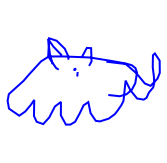

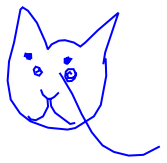

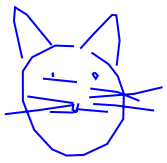

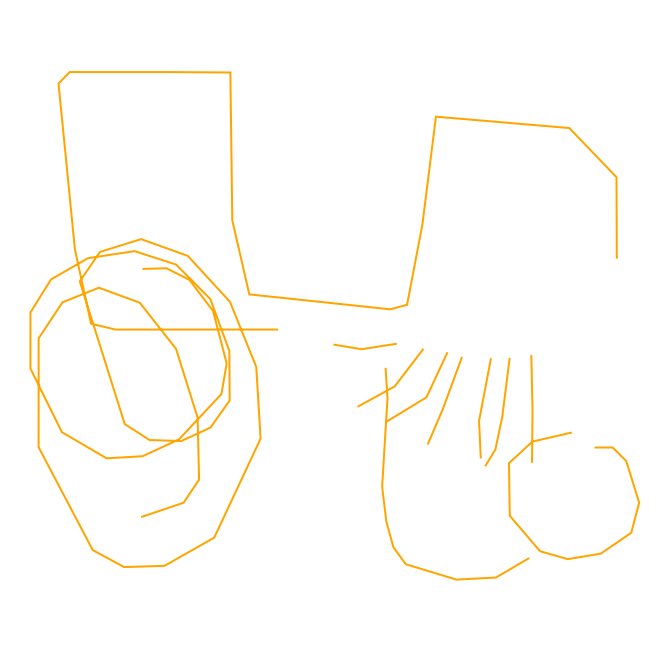

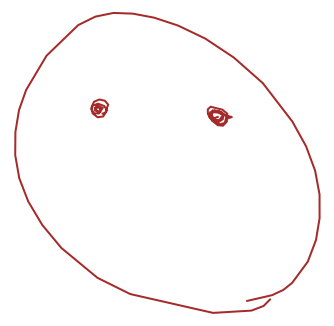

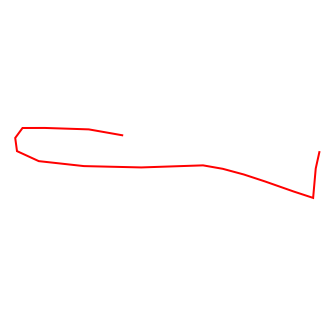

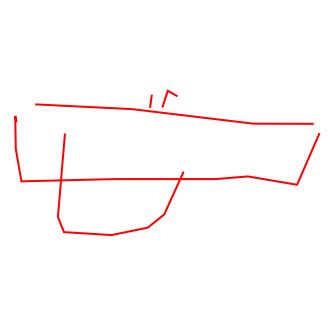

In [159]:
%%time
scene = df_to_scene(df)

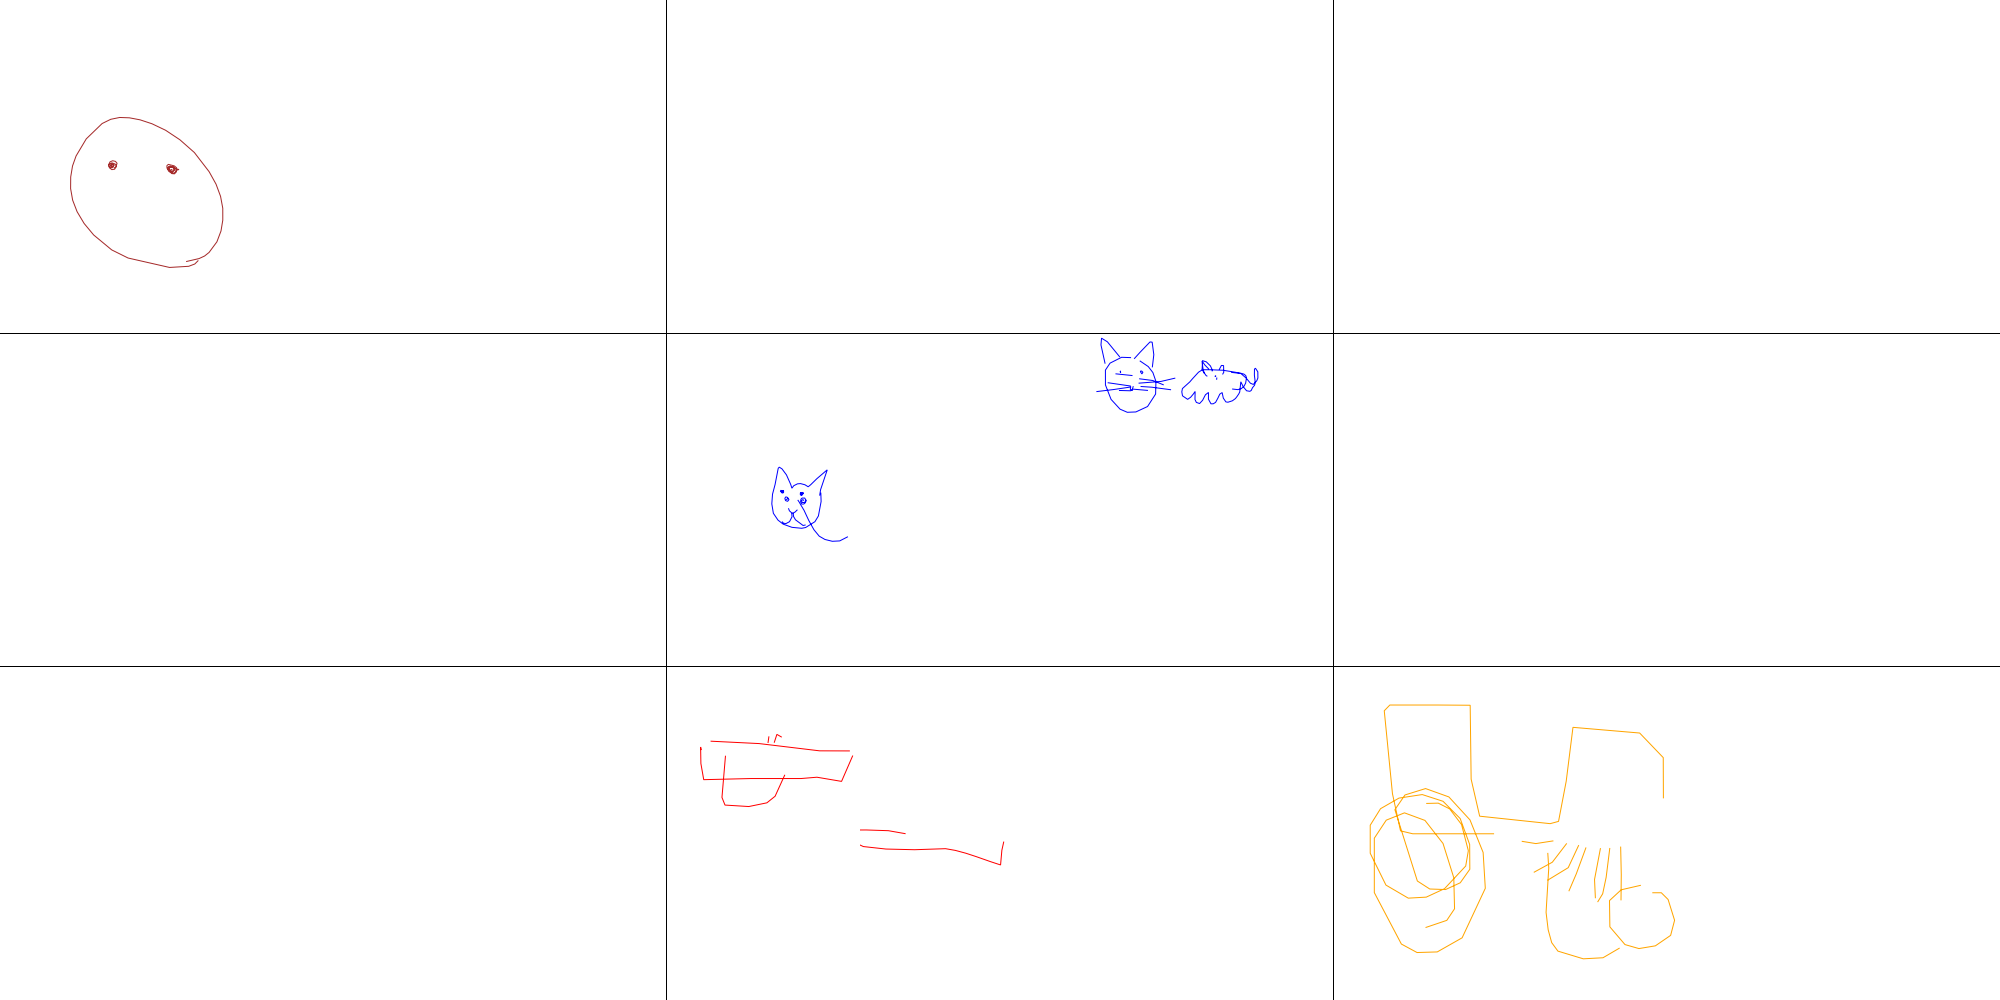

In [160]:
scene

In [1]:
import requests

In [30]:
url = 'http://127.0.0.1:8000/'
message = {'message' : 'draw me a little blue cat in the top left'}
response = requests.get(url, params=message)#.json()

# response[0].save('raw_data/scene_requested.png')
response.json()

JSONDecodeError: Expecting value: line 1 column 1 (char 0)